In [1]:
import json,os,glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import log

import seaborn as sns 
import statsmodels.formula.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet,ElasticNetCV,Lasso
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler


In [3]:
os.chdir('./data')

In [4]:
used_df = pd.read_excel('used_car_map.xlsx')

In [5]:
car_base = pd.read_excel('car_base.xlsx',encoding='utf-8')

In [5]:
# 모델 매핑 살아있는 데이터만 가져옴

In [6]:
car_base.columns = pd.Index(['model_id', 'brand', 'seg', 'title', 'duration', 'price_range',
       'recall_num'],
      dtype='object')
car_base = car_base[['model_id', 'brand', 'seg']]

In [7]:
car_base.model_id = pd.to_numeric(car_base.model_id,downcast='integer').astype('str')

In [8]:
used_df.model_id = pd.to_numeric(used_df.model_id,downcast='integer').astype('str')

In [9]:
used_df = used_df.loc[used_df[used_df.model_id != 'nan'].index,:]

In [10]:
used_df.model_id = pd.to_numeric(used_df.model_id,downcast='integer').astype('str')

In [11]:
used_df = pd.merge(used_df,car_base,on='model_id') # model id로 merge

In [12]:
used_df.sample().iloc[:,:15]

,demoNo,title,sub_title,baegi,year_old,color,driven_dist,trans,fuel,mortgage,tax_to_pay,ch_purpose,ch_num,ch_owner,total_loss
4638,8121500432,대형트럭(2.5톤이상) 마이티,e-마이티,3907.0,2012,흰색,470002,수동,경유,정보없음/정보없음,-,있음,2회,2회,0.0


전처리

In [13]:
used_df.drop(columns='theft',inplace=True)
used_df.drop(columns='mortgage',inplace=True)
used_df.drop(columns='tax_to_pay',inplace=True)
used_df.drop(columns='total_flood',inplace=True)
used_df.drop(columns='color',inplace=True)
used_df.drop(columns='description',inplace=True)

In [14]:
used_df.demoNo = used_df.demoNo.astype('str')
used_df.total_loss = used_df.total_loss.astype('category')
# used_df.total_flood = used_df.total_flood.astype('category')
used_df.part_flood = used_df.part_flood.astype('category')
used_df.model_id = used_df.model_id.astype('str')


In [15]:
used_df.ch_num = used_df.ch_num.str.replace(r'[^\d]','')
used_df.ch_owner = used_df.ch_owner.str.replace(r'[^\d]','')

In [16]:
used_df.loc[used_df[used_df.ch_num==''].index,'ch_num'] = 0
used_df.loc[used_df[used_df.ch_owner==''].index,'ch_owner'] = 0

In [17]:
used_df.loc[used_df[used_df.ch_purpose == '없음'].index, 'ch_purpose'] = 0
used_df.loc[used_df[used_df.ch_purpose == '있음'].index, 'ch_purpose'] = 1
used_df.ch_purpose.fillna(0,inplace=True)
used_df.ch_purpose = used_df.ch_purpose.astype('category')

In [18]:
used_df.total_loss.fillna(0,inplace=True)
used_df.total_loss = used_df.total_loss.astype('int32')
used_df.part_flood.fillna(0,inplace=True)
used_df.part_flood = used_df.part_flood.astype('int32')
used_df.damaged.fillna(0,inplace=True)
used_df.damaged = used_df.damaged.astype('int64')
used_df.damaging.fillna(0,inplace=True)
used_df.damaging = used_df.damaging.astype('int64')

In [19]:
used_df.loc[used_df.fuel=='LPG겸용','fuel'] = 'LPG'
used_df.loc[used_df.fuel=='휘발유+전기','fuel'] = '기타'
used_df.loc[used_df.fuel=='전기(EV)','fuel'] = '기타'
used_df.loc[used_df.fuel=='LPG+전기','fuel'] = '기타'

In [20]:
used_df.loc[used_df.trans=='세미오토','trans'] = '기타'
used_df.loc[used_df.trans=='무단변속기','trans'] = '자동'

In [21]:
used_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4994 entries, 0 to 4993
Data columns (total 24 columns):
demoNo         4994 non-null object
title          4994 non-null object
sub_title      4994 non-null object
baegi          4981 non-null float64
year_old       4994 non-null object
driven_dist    4994 non-null int64
trans          4994 non-null object
fuel           4994 non-null object
ch_purpose     4994 non-null category
ch_num         4994 non-null object
ch_owner       4994 non-null object
total_loss     4994 non-null int32
part_flood     4994 non-null int32
damaged        4994 non-null int64
damaging       4994 non-null int64
opt_prefer     4994 non-null object
opt_basic      4994 non-null object
opt_safe       4994 non-null object
opt_conven     4994 non-null object
opt_etc        4994 non-null object
price          4994 non-null int64
model_id       4994 non-null object
brand          4994 non-null object
seg            4994 non-null object
dtypes: category(1), float64(1),

옵션 데이터 처리

In [25]:
tmp_opt = pd.concat((used_df[['demoNo']],used_df.iloc[:,15:20]),axis=1)

In [26]:
tmp_opt.opt_prefer = pd.Series(map(eval,tmp_opt.opt_prefer))
tmp_opt.opt_basic = pd.Series(map(eval,tmp_opt.opt_basic))
tmp_opt.opt_safe = pd.Series(map(eval,tmp_opt.opt_safe))
tmp_opt.opt_conven = pd.Series(map(eval,tmp_opt.opt_conven))
tmp_opt.opt_etc = pd.Series(map(eval,tmp_opt.opt_etc))

In [27]:
records = []
for idx in range(len(tmp_opt)):
    row = tmp_opt.iloc[idx,:]
    
    record = [row.demoNo,]+row.opt_prefer + row.opt_basic + row.opt_safe + row.opt_conven+row.opt_etc
    records.append(record)

    

In [28]:
tmp_df = pd.DataFrame.from_records(records)

In [29]:
tmp_df.columns =  pd.Index(['demoNo',
       'navi_emb', 'rear_cam', 'sunroof', 'panoramic', 'button_start', 'blackbox',
       'fourWD', 'ISG', 'auto_air', 'alloy_wheel', 'head_lamp', 'seat_leather',
       'seat_power', 'seat_heat', 'seat_vent', 'MP3', 'airbag', 'airbag_suppot',
       'airbag_side', 'airbag_curtain', 'ABS', 'TCS', 'ESP_VDC', 'TPMS',
       'navi_mount', 'ECM', 'hi_pass', 'rear_sensor', 'forward_sensor', 'CC',
       'EPB', 'SPAS', 'steering_heat', 'TV_back', 'sliding_door', 'trunk_power',
       'side_step', 'HUD', 'LDWS', 'BSD'],
      dtype='object')

In [30]:
used_df.drop(columns='opt_prefer',inplace=True)
used_df.drop(columns='opt_basic',inplace=True)
used_df.drop(columns='opt_safe',inplace=True)
used_df.drop(columns='opt_conven',inplace=True)
used_df.drop(columns='opt_etc',inplace=True)

In [31]:
used_df = pd.merge(used_df,tmp_df,on='demoNo')

In [32]:
used_df.sample().iloc[:,:17]

,demoNo,title,sub_title,baegi,year_old,driven_dist,trans,fuel,ch_purpose,ch_num,ch_owner,total_loss,part_flood,damaged,damaging,price,model_id
1606,8031002108,현대 쏘나타뉴라이즈 하이브리드,프리미엄,1999.0,2018,4634,자동,기타,0,0,2,0,0,0,0,3150,3482


In [33]:
used_df.sample().iloc[:,17:]

,brand,seg,navi_emb,rear_cam,sunroof,panoramic,button_start,blackbox,fourWD,ISG,...,EPB,SPAS,steering_heat,TV_back,sliding_door,trunk_power,side_step,HUD,LDWS,BSD
153,현대,중형,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
used_df.set_index('demoNo',inplace=True)

In [35]:
used_df.year_old = used_df.year_old.str.replace(r'[^0-9]','')

In [36]:
used_df.year_old = used_df.year_old.str[:4]

In [37]:
used_df.loc[used_df.year_old == '111','year_old'] = ''

In [38]:
used_df.loc[used_df.year_old == '','year_old'] = float('nan')

In [39]:
used_df.year_old = used_df.year_old.astype('float32')

In [40]:
# used_df.color = used_df.color.astype('category')
used_df.trans = used_df.trans.astype('category')
used_df.fuel = used_df.fuel.astype('category')
used_df.ch_purpose = used_df.ch_purpose.astype('category')

In [41]:
used_df.ch_num = used_df.ch_num.str.replace(r'[\D]','')
used_df.loc[used_df.ch_num=='','ch_num'] = 0
used_df.ch_num.fillna(0,inplace=True)

In [42]:
used_df.ch_num = used_df.ch_num.astype('int32')

In [43]:
used_df.ch_owner = used_df.ch_owner.str.replace(r'[\D]','')
used_df.loc[used_df.ch_owner == '','ch_owner'] = 0
used_df.ch_owner.fillna(0,inplace=True)

In [44]:
used_df.ch_owner = used_df.ch_owner.astype('int32')

In [45]:
used_df.iloc[:,16:] = used_df.iloc[:,16:].astype('category')

In [46]:
used_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4994 entries, 8121501822 to 8121001200
Data columns (total 58 columns):
title             4994 non-null object
sub_title         4994 non-null object
baegi             4981 non-null float64
year_old          4992 non-null float32
driven_dist       4994 non-null int64
trans             4994 non-null category
fuel              4994 non-null category
ch_purpose        4994 non-null category
ch_num            4994 non-null int32
ch_owner          4994 non-null int32
total_loss        4994 non-null int32
part_flood        4994 non-null int32
damaged           4994 non-null int64
damaging          4994 non-null int64
price             4994 non-null int64
model_id          4994 non-null object
brand             4994 non-null category
seg               4994 non-null category
navi_emb          4994 non-null category
rear_cam          4994 non-null category
sunroof           4994 non-null category
panoramic         4994 non-null category
button_start 

In [47]:
used_df[['seg','brand','trans','fuel']].describe()

,seg,brand,trans,fuel
count,4994,4994,4994,4994
unique,12,32,3,4
top,중형,현대,자동,경유
freq,889,1730,4672,2453


In [48]:
used_df.groupby('seg').mean().price.sort_values()

seg
경차         622.717172
박스카        909.303030
준중형       1052.051753
상용        1059.887043
소형        1120.521277
중형        1157.878515
소형SUV     1487.282908
RV/MPV    1560.102639
중형SUV     1715.503386
준대형       1956.650456
대형SUV     2353.920455
대형        2463.847025
Name: price, dtype: float64

In [49]:
used_df.groupby('brand').mean().price.sort_values()

brand
닷지         445.000000
미쓰비시       690.000000
쉐보레        907.348442
르노삼성       953.113043
스바루       1030.000000
푸조        1095.862069
혼다        1104.058824
닛산        1158.695652
현대        1295.600578
볼보        1296.250000
기아        1300.443243
쌍용        1302.077295
폭스바겐      1370.000000
크라이슬러     1406.000000
피아트       1440.000000
인피니티      1517.107143
링컨        1530.000000
시트로엥      1580.000000
토요타       1755.000000
미니        1815.769231
포드        1860.476190
렉서스       1940.000000
BMW       2370.854271
지프        2484.074074
아우디       2618.400000
캐딜락       2663.076923
재규어       2869.214286
벤츠        3036.648352
랜드로버      3824.000000
제네시스      4656.774194
포르쉐       5076.666667
벤틀리      16500.000000
Name: price, dtype: float64

In [50]:
used_df.brand = used_df.brand.astype('str')

In [51]:
used_df.loc[used_df.brand=='기타','brand'] = '기타1'
used_df.loc[used_df.brand=='닷지','brand'] = '기타1'
used_df.loc[used_df.brand=='미쓰비시','brand'] = '기타1'
used_df.loc[used_df.brand=='스바루','brand'] = '기타1'
used_df.loc[used_df.brand=='푸조','brand'] = '기타1'
used_df.loc[used_df.brand=='혼다','brand'] = '기타1'
used_df.loc[used_df.brand=='닛산','brand'] = '기타1'
used_df.loc[used_df.brand=='볼보','brand'] = '기타1'

In [52]:
used_df.loc[used_df.brand=='인피니티','brand'] = '기타2'
used_df.loc[used_df.brand=='지프','brand'] = '기타2'
used_df.loc[used_df.brand=='미니','brand'] = '기타2'
used_df.loc[used_df.brand=='인피니티','brand'] = '기타2'
used_df.loc[used_df.brand=='포드','brand'] = '기타2'
used_df.loc[used_df.brand=='토요타','brand'] = '기타2'
used_df.loc[used_df.brand=='렉서스','brand'] = '기타2'
used_df.loc[used_df.brand=='재규어','brand'] = '기타2'
used_df.loc[used_df.brand=='링컨','brand'] = '기타2'
used_df.loc[used_df.brand=='캐딜락','brand'] = '기타2'
used_df.loc[used_df.brand=='크라이슬러','brand'] = '기타2'
used_df.loc[used_df.brand=='랜드로버','brand'] = '기타2'
used_df.loc[used_df.brand=='인피니티','brand'] = '기타2'
used_df.loc[used_df.brand=='시트로엥','brand'] = '기타2'
used_df.loc[used_df.brand=='포르쉐','brand'] = '기타2'
used_df.loc[used_df.brand=='피아트','brand'] = '기타2'
used_df.loc[used_df.brand=='벤틀리','brand'] = '기타2'

In [53]:
used_df.brand.value_counts().sort_values(ascending=False)

현대      1730
기아      1480
쉐보레      353
르노삼성     230
기타2      213
쌍용       207
BMW      199
벤츠       182
폭스바겐     151
아우디      125
기타1       93
제네시스      31
Name: brand, dtype: int64

In [54]:
used_df.brand = used_df.brand.astype('category')

In [55]:
used_df.groupby('trans').mean().price.sort_values()

trans
수동     776.661184
기타    1486.111111
자동    1493.045163
Name: price, dtype: float64

In [56]:
used_df.groupby('fuel').mean().price.sort_values()

fuel
LPG     828.501199
휘발유    1385.779144
경유     1594.973094
기타     1792.516484
Name: price, dtype: float64

In [56]:
# used_df.to_excel('used_df_190218.xlsx',encoding='utf-8')

명목변수 one hot encoding

In [57]:
used_df2 = pd.get_dummies(used_df,columns=['brand','trans','fuel']) 

In [58]:
used_df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4994 entries, 8121501822 to 8121001200
Data columns (total 74 columns):
title             4994 non-null object
sub_title         4994 non-null object
baegi             4981 non-null float64
year_old          4992 non-null float32
driven_dist       4994 non-null int64
ch_purpose        4994 non-null category
ch_num            4994 non-null int32
ch_owner          4994 non-null int32
total_loss        4994 non-null int32
part_flood        4994 non-null int32
damaged           4994 non-null int64
damaging          4994 non-null int64
price             4994 non-null int64
model_id          4994 non-null object
seg               4994 non-null category
navi_emb          4994 non-null category
rear_cam          4994 non-null category
sunroof           4994 non-null category
panoramic         4994 non-null category
button_start      4994 non-null category
blackbox          4994 non-null category
fourWD            4994 non-null category
ISG          

In [59]:
model_seg = pd.read_excel('RU2_seg_detail.xlsx',encoding='utf-8') # 세부 세그먼트 라벨링된 데이터 불러오기

In [60]:
model_seg.model = model_seg.model.astype('str')

In [61]:
model_seg.columns = pd.Index(['model_id', 'brand', 'seg', 'title', 'lenth', 'width', 'height',
       'wheel_base', 'mid_p', 'predict'],
      dtype='object')

In [62]:
# 소형만
used_ru2 = pd.merge(used_df2[used_df2.seg=='소형SUV'], model_seg, on='model_id').drop(columns=['brand','seg_y','title_y','lenth','width','height','wheel_base','mid_p'])
used_ru2.predict = used_ru2.predict.astype('str')

In [63]:
# 차종전체

In [64]:
used_df = used_ru2

EDA

In [65]:
used_df.describe()

,baegi,year_old,driven_dist,ch_num,ch_owner,total_loss,part_flood,damaged,damaging,price,...,brand_제네시스,brand_폭스바겐,brand_현대,trans_기타,trans_수동,trans_자동,fuel_LPG,fuel_경유,fuel_기타,fuel_휘발유
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,5.060000e+02,5.060000e+02,506.000000,...,506.0,506.000000,506.000000,506.0,506.000000,506.000000,506.0,506.000000,506.000000,506.000000
mean,1842.027668,2014.758911,76884.286561,0.258893,1.108696,0.011858,0.001976,1.717879e+06,6.875320e+05,1483.333992,...,0.0,0.059289,0.256917,0.0,0.001976,0.998024,0.0,0.816206,0.015810,0.167984
std,338.632479,2.296178,53123.424439,0.451806,1.350483,0.108353,0.044455,6.705212e+06,2.444426e+06,571.605761,...,0.0,0.236398,0.437366,0.0,0.044455,0.044455,0.0,0.387700,0.124864,0.374222
min,0.000000,2006.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,490.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,1598.000000,2014.000000,32082.500000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1090.000000,...,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.0,1.000000,0.000000,0.000000
50%,1995.000000,2015.000000,70000.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1400.000000,...,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.0,1.000000,0.000000,0.000000
75%,1995.000000,2016.000000,108640.000000,1.000000,2.000000,0.000000,0.000000,1.147502e+06,4.827425e+05,1730.000000,...,0.0,0.000000,1.000000,0.0,0.000000,1.000000,0.0,1.000000,0.000000,0.000000
max,3604.000000,2019.000000,283591.000000,2.000000,10.000000,1.000000,1.000000,1.222210e+08,2.808662e+07,5200.000000,...,0.0,1.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


In [66]:
used_df.describe(include='object')

,title_x,sub_title,model_id,predict
count,506,506,506,506
unique,38,172,38,3
top,현대 올뉴투싼(TL),디젤 2WD 프레스티지,3250,1
freq,61,15,61,358


In [67]:
used_df.predict.value_counts()

1    358
0    131
2     17
Name: predict, dtype: int64

In [68]:
used_df[used_df.predict == '1'].describe(include='category').iloc[:,:15]

,ch_purpose,seg_x,navi_emb,rear_cam,sunroof,panoramic,button_start,blackbox,fourWD,ISG,auto_air,alloy_wheel,head_lamp,seat_leather,seat_power
count,358,358,358,358,358,358,358,358,358,358,358,358,358,358,358
unique,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2
top,0,소형SUV,0,0,0,0,0,0,0,0,0,0,0,0,0
freq,261,358,182,192,339,267,191,257,316,326,216,189,290,192,269


In [69]:
used_df[used_df.predict == '1'].describe(include='category').iloc[:,15:30]

,seat_heat,seat_vent,MP3,airbag,airbag_suppot,airbag_side,airbag_curtain,ABS,TCS,ESP_VDC,TPMS,navi_mount,ECM,hi_pass,rear_sensor
count,358,358,358,358,358,358,358,358,358,358,358,358,358,358,358
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
freq,187,285,214,186,188,222,242,196,258,262,265,345,248,261,211


In [70]:
used_df[used_df.predict == '1'].describe(include='category').iloc[:,30:]

,forward_sensor,CC,EPB,SPAS,steering_heat,TV_back,sliding_door,trunk_power,side_step,HUD,LDWS,BSD
count,358,358,358,358,358,358,358,358,358,358,358,358
unique,2,2,2,2,2,2,2,2,2,2,2,2
top,0,0,0,0,0,0,0,0,0,0,0,0
freq,309,272,323,346,282,353,354,349,345,354,351,353


In [71]:
used_df.describe(include='category').iloc[:,:15]

,ch_purpose,seg_x,navi_emb,rear_cam,sunroof,panoramic,button_start,blackbox,fourWD,ISG,auto_air,alloy_wheel,head_lamp,seat_leather,seat_power
count,506,506,506,506,506,506,506,506,506,506,506,506,506,506,506
unique,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2
top,0,소형SUV,0,0,0,0,0,0,0,0,0,0,0,0,0
freq,391,506,265,266,468,398,273,361,450,460,308,265,409,275,375


In [72]:
used_df.describe(include='category').iloc[:,15:30]

,seat_heat,seat_vent,MP3,airbag,airbag_suppot,airbag_side,airbag_curtain,ABS,TCS,ESP_VDC,TPMS,navi_mount,ECM,hi_pass,rear_sensor
count,506,506,506,506,506,506,506,506,506,506,506,506,506,506,506
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
freq,263,407,312,263,268,312,340,279,373,371,368,488,343,363,300


In [73]:
used_df.describe(include='category').iloc[:,30:]

,forward_sensor,CC,EPB,SPAS,steering_heat,TV_back,sliding_door,trunk_power,side_step,HUD,LDWS,BSD
count,506,506,506,506,506,506,506,506,506,506,506,506
unique,2,2,2,2,2,2,2,2,2,2,2,2
top,0,0,0,0,0,0,0,0,0,0,0,0
freq,433,375,463,491,400,499,500,493,490,494,489,488


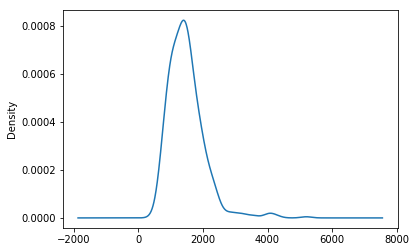

In [74]:
used_df.price.plot.density()

In [75]:
# numeric_lst = list(used_df.describe().columns)
numeric_lst = ['baegi',
 'year_old',
#  'driven_dist',
 'ch_num',
 'ch_owner',
 'total_loss',
 'part_flood',
 'price']

In [76]:
numeric_big_lst = ['damaged',
 'damaging']

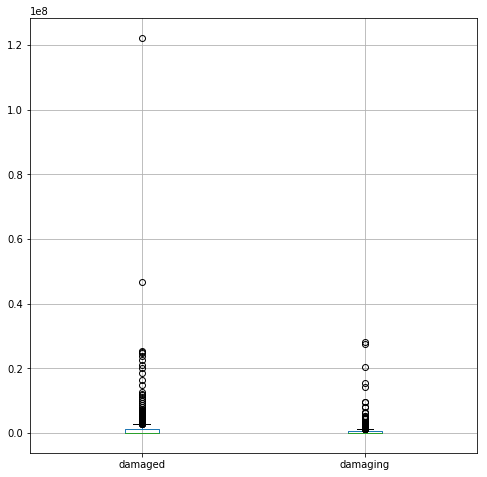

In [77]:
plt.figure(figsize=(8,8))
used_df.boxplot(column = numeric_big_lst)

In [78]:
used_df.damaged.describe()

count    5.060000e+02
mean     1.717879e+06
std      6.705212e+06
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.147502e+06
max      1.222210e+08
Name: damaged, dtype: float64

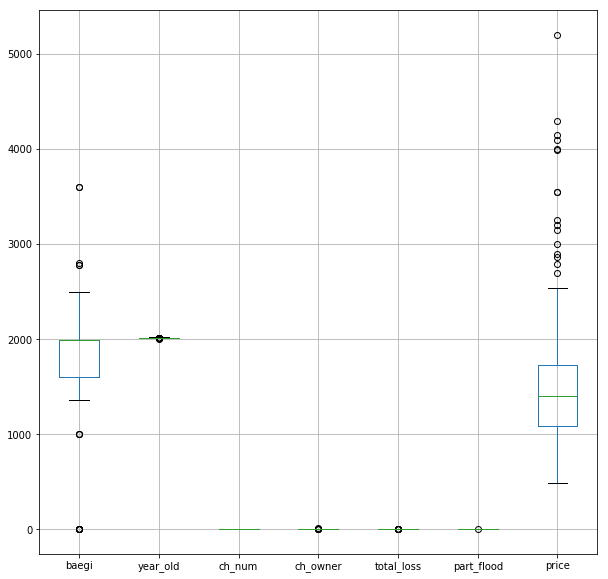

In [79]:
plt.figure(figsize=(10,10))
used_df.boxplot(column = numeric_lst)

In [81]:
used_df.driven_dist.describe()

count       506.000000
mean      76884.286561
std       53123.424439
min          20.000000
25%       32082.500000
50%       70000.000000
75%      108640.000000
max      283591.000000
Name: driven_dist, dtype: float64

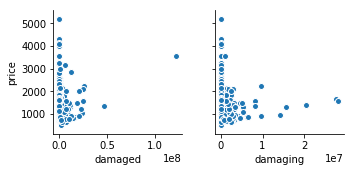

In [180]:
sns.pairplot(used_df,y_vars='price',x_vars=numeric_big_lst)#,height=10)

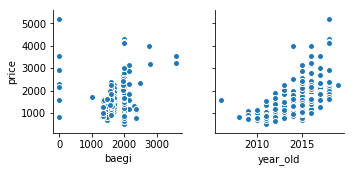

In [181]:
sns.pairplot(used_df,y_vars='price',x_vars=numeric_lst[:2])#,height=10)

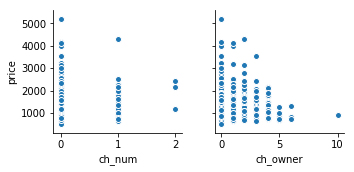

In [182]:
sns.pairplot(used_df,y_vars='price',x_vars=numeric_lst[2:4])#,height=10)

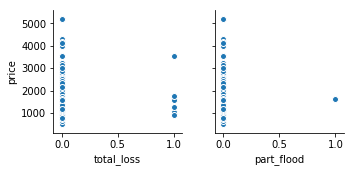

In [183]:
sns.pairplot(used_df,y_vars='price',x_vars=numeric_lst[4:6])#,height=10)

In [70]:
opt_names = ['navi_emb', 'rear_cam', 'sunroof', 'panoramic', 'button_start',
       'blackbox', 'fourWD', 'ISG', 'auto_air', 'alloy_wheel', 'head_lamp',
       'seat_leather', 'seat_power', 'seat_heat', 'seat_vent', 'MP3', 'airbag',
       'airbag_suppot', 'airbag_side', 'airbag_curtain', 'ABS', 'TCS',
       'ESP_VDC', 'TPMS', 'navi_mount', 'ECM', 'hi_pass', 'rear_sensor',
       'forward_sensor', 'CC', 'EPB', 'SPAS', 'steering_heat', 'TV_back',
       'sliding_door', 'trunk_power', 'side_step', 'HUD', 'LDWS', 'BSD']

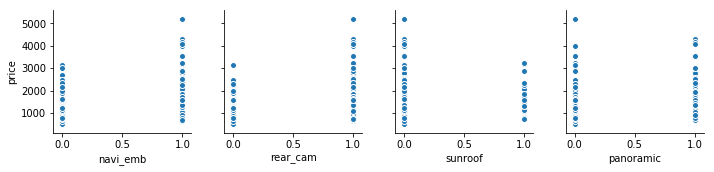

In [186]:
sns.pairplot(used_df,y_vars='price',x_vars=opt_names[:4])#,height=5)

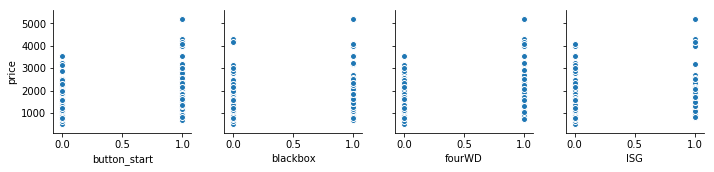

In [187]:
sns.pairplot(used_df,y_vars='price',x_vars=opt_names[4:8])

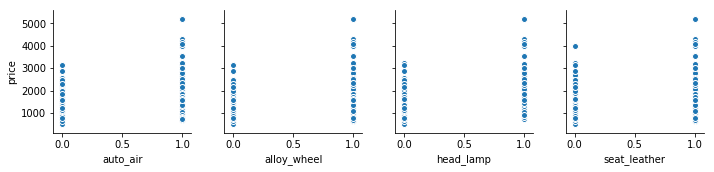

In [188]:
sns.pairplot(used_df,y_vars='price',x_vars=opt_names[8:12])

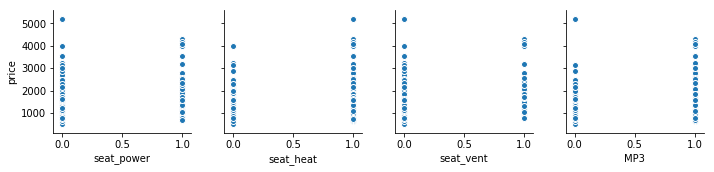

In [190]:
sns.pairplot(used_df,y_vars='price',x_vars=opt_names[12:16])

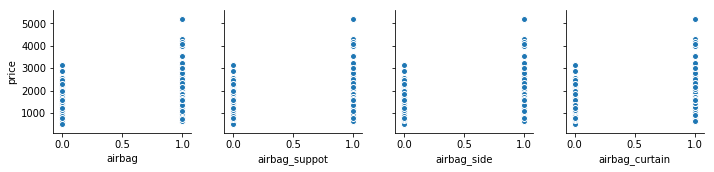

In [191]:
sns.pairplot(used_df,y_vars='price',x_vars=opt_names[16:20])

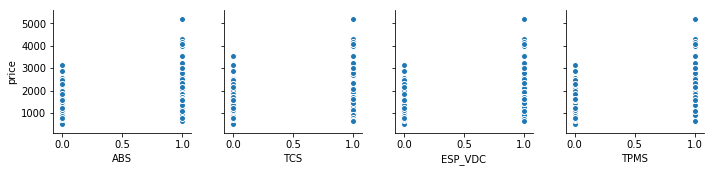

In [192]:
sns.pairplot(used_df,y_vars='price',x_vars=opt_names[20:24])

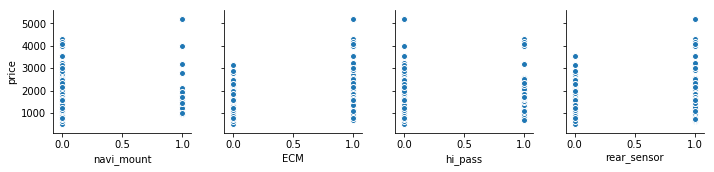

In [193]:
sns.pairplot(used_df,y_vars='price',x_vars=opt_names[24:28])

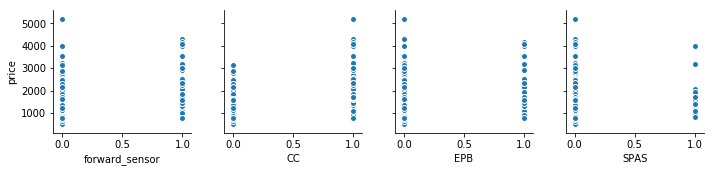

In [194]:
sns.pairplot(used_df,y_vars='price',x_vars=opt_names[28:32])

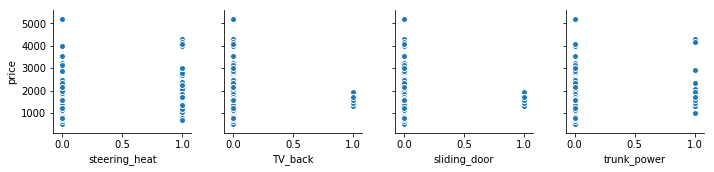

In [195]:
sns.pairplot(used_df,y_vars='price',x_vars=opt_names[32:36])

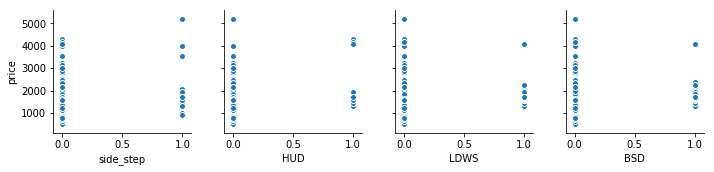

In [196]:
sns.pairplot(used_df,y_vars='price',x_vars=opt_names[36:])

In [404]:
# for opt in opt_names:
#     print( used_df.groupby(opt)[['price']].mean(),end='\n\n')

In [82]:
used_df = used_df.sort_values('price') # price 로그변환

In [83]:
used_df.loc[:,'model_id'] = used_df.model_id.astype('str')

In [84]:
used_df.price = pd.Series(map(log, used_df.price),index=used_df.index)

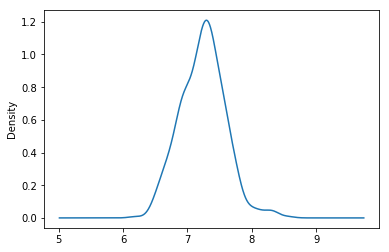

In [85]:
used_df.price.plot.density()

In [86]:
used_df.describe(include='category').columns

Index(['ch_purpose', 'seg_x', 'navi_emb', 'rear_cam', 'sunroof', 'panoramic',
       'button_start', 'blackbox', 'fourWD', 'ISG', 'auto_air', 'alloy_wheel',
       'head_lamp', 'seat_leather', 'seat_power', 'seat_heat', 'seat_vent',
       'MP3', 'airbag', 'airbag_suppot', 'airbag_side', 'airbag_curtain',
       'ABS', 'TCS', 'ESP_VDC', 'TPMS', 'navi_mount', 'ECM', 'hi_pass',
       'rear_sensor', 'forward_sensor', 'CC', 'EPB', 'SPAS', 'steering_heat',
       'TV_back', 'sliding_door', 'trunk_power', 'side_step', 'HUD', 'LDWS',
       'BSD'],
      dtype='object')

In [87]:
for col in ['ch_purpose', 'navi_emb', 'rear_cam', 'sunroof', 'panoramic',
       'button_start', 'blackbox', 'fourWD', 'ISG', 'auto_air', 'alloy_wheel',
       'head_lamp', 'seat_leather', 'seat_power', 'seat_heat', 'seat_vent',
       'MP3', 'airbag', 'airbag_suppot', 'airbag_side', 'airbag_curtain',
       'ABS', 'TCS', 'ESP_VDC', 'TPMS', 'navi_mount', 'ECM', 'hi_pass',
       'rear_sensor', 'forward_sensor', 'CC', 'EPB', 'SPAS', 'steering_heat',
       'TV_back', 'sliding_door', 'trunk_power', 'side_step', 'HUD', 'LDWS',
       'BSD']:
    used_df.loc[:,col] = used_df.loc[:,col].astype('uint8')

In [90]:
used_df.title_x.value_counts()

현대 올뉴투싼(TL)       61
기아 스포티지4세대        56
기아 더뉴스포티지R        51
현대 투싼ix(LM)       38
기아 스포티지R          35
쌍용 티볼리            31
폭스바겐 티구안(1세대)     30
쌍용 뉴코란도C          23
현대 뉴투싼ix(LM)      23
쉐보레/대우 트랙스        19
미니 컨트리맨(1세대)      16
쉐보레/대우 더뉴트랙스      15
르노삼성 QM3          12
쌍용 티볼리에어          10
쌍용 코란도C            8
현대 코나              8
기아 니로              8
쌍용 티볼리아머           7
기아 스토닉             7
지프 컴패스(1세대)        6
지프 레니게이드           4
쌍용 뉴스타일코란도C        4
지프 랭글러(JK)         4
BMW X1(E84)        4
아우디 Q3             4
닛산 쥬크              4
벤츠 GLA클래스          3
미니 컨트리맨(2세대)       3
푸조 2008(1세대)       2
닛산 캐시카이            2
피아트 500X           1
지프 랭글러(JL)         1
토요타 RAV4           1
르노삼성 뉴QM3          1
랜드로버 레인지로버스포츠      1
랜드로버 디스커버리스포츠      1
포드 쿠가(2세대)         1
기아 스포티지            1
Name: title_x, dtype: int64

In [91]:
used_df.columns

Index(['title_x', 'sub_title', 'baegi', 'year_old', 'driven_dist',
       'ch_purpose', 'ch_num', 'ch_owner', 'total_loss', 'part_flood',
       'damaged', 'damaging', 'price', 'model_id', 'seg_x', 'navi_emb',
       'rear_cam', 'sunroof', 'panoramic', 'button_start', 'blackbox',
       'fourWD', 'ISG', 'auto_air', 'alloy_wheel', 'head_lamp', 'seat_leather',
       'seat_power', 'seat_heat', 'seat_vent', 'MP3', 'airbag',
       'airbag_suppot', 'airbag_side', 'airbag_curtain', 'ABS', 'TCS',
       'ESP_VDC', 'TPMS', 'navi_mount', 'ECM', 'hi_pass', 'rear_sensor',
       'forward_sensor', 'CC', 'EPB', 'SPAS', 'steering_heat', 'TV_back',
       'sliding_door', 'trunk_power', 'side_step', 'HUD', 'LDWS', 'BSD',
       'brand_BMW', 'brand_기아', 'brand_기타1', 'brand_기타2', 'brand_르노삼성',
       'brand_벤츠', 'brand_쉐보레', 'brand_쌍용', 'brand_아우디', 'brand_제네시스',
       'brand_폭스바겐', 'brand_현대', 'trans_기타', 'trans_수동', 'trans_자동',
       'fuel_LPG', 'fuel_경유', 'fuel_기타', 'fuel_휘발유', 'predict'],
      d

차급별 모델링

In [99]:
used_df0 = used_df[used_df.predict=='0']
y0 = used_df0[['price']]
# sklearn 전처리 필요
X0 = used_df0[['baegi', 'year_old', 'driven_dist',
       'ch_purpose', 'ch_num', 'ch_owner', 'total_loss', 'part_flood',
       'damaged', 'damaging', 'model_id', 'navi_emb',
       'rear_cam', 'sunroof', 'panoramic', 'button_start', 'blackbox',
       'fourWD', 'ISG', 'auto_air', 'alloy_wheel', 'head_lamp', 'seat_leather',
       'seat_power', 'seat_heat', 'seat_vent', 'MP3', 'airbag',
       'airbag_suppot', 'airbag_side', 'airbag_curtain', 'ABS', 'TCS',
       'ESP_VDC', 'TPMS', 'navi_mount', 'ECM', 'hi_pass', 'rear_sensor',
       'forward_sensor', 'CC', 'EPB', 'SPAS', 'steering_heat', 'TV_back',
       'sliding_door', 'trunk_power', 'side_step', 'HUD', 'LDWS', 'BSD',
       'brand_BMW', 'brand_기아', 'brand_기타1', 'brand_기타2', 'brand_르노삼성',
       'brand_벤츠', 'brand_쉐보레', 'brand_쌍용', 'brand_아우디', 'brand_제네시스',
       'brand_폭스바겐', 'brand_현대', 'trans_기타', 'trans_수동', 'trans_자동',
       'fuel_LPG', 'fuel_경유', 'fuel_기타', 'fuel_휘발유'
            ]]
X0 = pd.get_dummies(X0,columns=['model_id'])

In [100]:
X0.columns

Index(['baegi', 'year_old', 'driven_dist', 'ch_purpose', 'ch_num', 'ch_owner',
       'total_loss', 'part_flood', 'damaged', 'damaging', 'navi_emb',
       'rear_cam', 'sunroof', 'panoramic', 'button_start', 'blackbox',
       'fourWD', 'ISG', 'auto_air', 'alloy_wheel', 'head_lamp', 'seat_leather',
       'seat_power', 'seat_heat', 'seat_vent', 'MP3', 'airbag',
       'airbag_suppot', 'airbag_side', 'airbag_curtain', 'ABS', 'TCS',
       'ESP_VDC', 'TPMS', 'navi_mount', 'ECM', 'hi_pass', 'rear_sensor',
       'forward_sensor', 'CC', 'EPB', 'SPAS', 'steering_heat', 'TV_back',
       'sliding_door', 'trunk_power', 'side_step', 'HUD', 'LDWS', 'BSD',
       'brand_BMW', 'brand_기아', 'brand_기타1', 'brand_기타2', 'brand_르노삼성',
       'brand_벤츠', 'brand_쉐보레', 'brand_쌍용', 'brand_아우디', 'brand_제네시스',
       'brand_폭스바겐', 'brand_현대', 'trans_기타', 'trans_수동', 'trans_자동',
       'fuel_LPG', 'fuel_경유', 'fuel_기타', 'fuel_휘발유', 'model_id_2445',
       'model_id_3054', 'model_id_3080', 'model_id_3115', 'mode

In [101]:
X0.damaged.fillna(0,inplace=True)
X0.damaging.fillna(0,inplace=True)
drop_idx = X0[X0.year_old.isna()].index
X0.drop(index=drop_idx,inplace=True)
y0.drop(index=drop_idx,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [102]:
drop_idx = X0[X0.baegi.isna()].index
X0.drop(index=drop_idx,inplace=True)
y0.drop(index=drop_idx,inplace=True)

변수 스케일링

In [103]:
scaler = StandardScaler()
X0 = scaler.fit_transform(X0)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


CV로 하이퍼 파라미터 튜닝

In [104]:
x_train, x_test, y_train, y_test= train_test_split(X0, y0, test_size=0.3, random_state =0)

cv_model = ElasticNetCV(l1_ratio=[ .1, .5, .7, .9, .95, .99, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                    normalize=True, precompute='auto', max_iter=500, tol=0.0001, cv=5, 
                    copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=None, selection='cyclic')

cv_model.fit(x_train, y_train)



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to incr

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=500,
       n_alphas=100, n_jobs=-1, normalize=True, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

최적 모델 선택 후 학습

In [105]:
model = ElasticNet(l1_ratio=cv_model.l1_ratio_, alpha = cv_model.alpha_, max_iter=cv_model.n_iter_, fit_intercept=True, normalize = True)
model.fit(x_train, y_train)

ElasticNet(alpha=0.0013768774094722646, copy_X=True, fit_intercept=True,
      l1_ratio=0.7, max_iter=75, normalize=True, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)

In [106]:
r2_score(y_test, model.predict(x_test))

0.894177701753735

In [107]:
model.get_params()

{'alpha': 0.0013768774094722646,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.7,
 'max_iter': 75,
 'normalize': True,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

변수 계수저장

In [121]:
var_coef = pd.concat(
        (pd.DataFrame(['baegi', 'year_old', 'driven_dist',
       'ch_purpose', 'ch_num', 'ch_owner', 'total_loss', 'part_flood',
       'damaged', 'damaging', 'model_id', 'navi_emb',
       'rear_cam', 'sunroof', 'panoramic', 'button_start', 'blackbox',
       'fourWD', 'ISG', 'auto_air', 'alloy_wheel', 'head_lamp', 'seat_leather',
       'seat_power', 'seat_heat', 'seat_vent', 'MP3', 'airbag',
       'airbag_suppot', 'airbag_side', 'airbag_curtain', 'ABS', 'TCS',
       'ESP_VDC', 'TPMS', 'navi_mount', 'ECM', 'hi_pass', 'rear_sensor',
       'forward_sensor', 'CC', 'EPB', 'SPAS', 'steering_heat', 'TV_back',
       'sliding_door', 'trunk_power', 'side_step', 'HUD', 'LDWS', 'BSD',
       'brand_BMW', 'brand_기아', 'brand_기타1', 'brand_기타2', 'brand_르노삼성',
       'brand_벤츠', 'brand_쉐보레', 'brand_쌍용', 'brand_아우디', 'brand_제네시스',
       'brand_폭스바겐', 'brand_현대', 'trans_기타', 'trans_수동', 'trans_자동',
       'fuel_LPG', 'fuel_경유', 'fuel_기타', 'fuel_휘발유'
            ],columns=['var'])
           ,pd.DataFrame(model.coef_,columns=['coef'])
        ),axis=1
)

In [441]:
var_coef.sort_values('coef',ascending=False).to_excel('Enet_coef_seg0.xlsx',encoding='utf-8')

같은 과정 준중형으로 진행

In [108]:
used_df1 = used_df[used_df.predict=='1']
y1 = used_df1[['price']]
# sklearn 전처리 필요
X1 = used_df1[['baegi', 'year_old', 'driven_dist',
       'ch_purpose', 'ch_num', 'ch_owner', 'total_loss', 'part_flood',
       'damaged', 'damaging', 'model_id', 'navi_emb',
       'rear_cam', 'sunroof', 'panoramic', 'button_start', 'blackbox',
       'fourWD', 'ISG', 'auto_air', 'alloy_wheel', 'head_lamp', 'seat_leather',
       'seat_power', 'seat_heat', 'seat_vent', 'MP3', 'airbag',
       'airbag_suppot', 'airbag_side', 'airbag_curtain', 'ABS', 'TCS',
       'ESP_VDC', 'TPMS', 'navi_mount', 'ECM', 'hi_pass', 'rear_sensor',
       'forward_sensor', 'CC', 'EPB', 'SPAS', 'steering_heat', 'TV_back',
       'sliding_door', 'trunk_power', 'side_step', 'HUD', 'LDWS', 'BSD',
       'brand_BMW', 'brand_기아', 'brand_기타1', 'brand_기타2', 'brand_르노삼성',
       'brand_벤츠', 'brand_쉐보레', 'brand_쌍용', 'brand_아우디', 'brand_제네시스',
       'brand_폭스바겐', 'brand_현대', 'trans_기타', 'trans_수동', 'trans_자동',
       'fuel_LPG', 'fuel_경유', 'fuel_기타', 'fuel_휘발유'
            ]]
X1 = pd.get_dummies(X1,columns=['model_id'])

In [109]:
len(X1)

358

In [110]:
len(X1.columns)

86

In [111]:
X1.damaged.fillna(0,inplace=True)
X1.damaging.fillna(0,inplace=True)
drop_idx = X1[X1.year_old.isna()].index
drop_idx
X1.drop(index=drop_idx,inplace=True)
y1.drop(index=drop_idx,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [112]:
drop_idx = X1[X1.baegi.isna()].index
X1.drop(index=drop_idx,inplace=True)
y1.drop(index=drop_idx,inplace=True)

In [114]:
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [115]:
x_train, x_test, y_train, y_test= train_test_split(X1, y1, test_size=0.3, random_state =0)

cv_model = ElasticNetCV(l1_ratio=[ .1, .5, .7, .9, .95, .99, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                    normalize=True, precompute='auto', max_iter=500, tol=0.0001, cv=5, 
                    copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=None, selection='cyclic')

cv_model.fit(x_train, y_train)



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=500,
       n_alphas=100, n_jobs=-1, normalize=True, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

In [116]:
model = ElasticNet(l1_ratio=cv_model.l1_ratio_, alpha = cv_model.alpha_, max_iter=cv_model.n_iter_, fit_intercept=True, normalize = True)
model.fit(x_train, y_train)

ElasticNet(alpha=0.00033963397059003574, copy_X=True, fit_intercept=True,
      l1_ratio=0.5, max_iter=75, normalize=True, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)

In [117]:
r2_score(y_test, model.predict(x_test))

0.878626333813608

In [118]:
model.get_params()

{'alpha': 0.00033963397059003574,
 'copy_X': True,
 'fit_intercept': True,
 'l1_ratio': 0.5,
 'max_iter': 75,
 'normalize': True,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [123]:
var_coef = pd.concat(
        (pd.DataFrame(['baegi', 'year_old', 'driven_dist',
       'ch_purpose', 'ch_num', 'ch_owner', 'total_loss', 'part_flood',
       'damaged', 'damaging', 'model_id', 'navi_emb',
       'rear_cam', 'sunroof', 'panoramic', 'button_start', 'blackbox',
       'fourWD', 'ISG', 'auto_air', 'alloy_wheel', 'head_lamp', 'seat_leather',
       'seat_power', 'seat_heat', 'seat_vent', 'MP3', 'airbag',
       'airbag_suppot', 'airbag_side', 'airbag_curtain', 'ABS', 'TCS',
       'ESP_VDC', 'TPMS', 'navi_mount', 'ECM', 'hi_pass', 'rear_sensor',
       'forward_sensor', 'CC', 'EPB', 'SPAS', 'steering_heat', 'TV_back',
       'sliding_door', 'trunk_power', 'side_step', 'HUD', 'LDWS', 'BSD',
       'brand_BMW', 'brand_기아', 'brand_기타1', 'brand_기타2', 'brand_르노삼성',
       'brand_벤츠', 'brand_쉐보레', 'brand_쌍용', 'brand_아우디', 'brand_제네시스',
       'brand_폭스바겐', 'brand_현대', 'trans_기타', 'trans_수동', 'trans_자동',
       'fuel_LPG', 'fuel_경유', 'fuel_기타', 'fuel_휘발유'
            ],columns=['var'])
           ,pd.DataFrame(model.coef_,columns=['coef'])
        ),axis=1
)

In [201]:
var_coef.sort_values('coef',ascending=False).to_excel('Enet_coef_seg1.xlsx',encoding='utf-8')